# EPM Visualization Gallery

> **Handbook:** See [Lattice EPM Spatial Fields](../../docs/source/models/epm/lattice_epm.rst#field-initialization) and [Tensorial EPM](../../docs/source/models/epm/tensorial_epm.rst) for details on stress field structure.

**EPM Spatial Visualization:** EPM simulations produce **spatially-resolved stress fields** on a 2D lattice ($L \times L$), revealing stress heterogeneity, avalanche dynamics, and shear banding. RheoJAX provides auto-detection tools to visualize scalar (LatticeEPM) vs tensorial (TensorialEPM) stress fields.

### Field Types

| Model | Stress Field | Shape | Components |
|-------|-------------|-------|------------|
| **LatticeEPM** | Scalar | `(L, L)` | $\sigma_{xy}$ only (shear stress) |
| **TensorialEPM** | Tensor | `(3, L, L)` | $\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{xy}$ (full planar stress) |

### Physical Interpretation

**Stress heterogeneity** in EPM arises from:
- **Quenched disorder** in yield thresholds $\sigma_{c,i}$ (Gaussian distribution)
- **Eshelby stress redistribution** ($\mathcal{G}_{ij}$ quadrupolar propagator)
- **Plastic avalanches** (cascading yielding events)

**Spatial patterns reveal:**
- **Stress localization** → potential shear band nucleation sites
- **Yielding maps** ($|\sigma_i| \ge \sigma_{c,i}$) → active plasticity regions
- **Normal stress gradients** ($\nabla N_1$) → flow instabilities in TensorialEPM

### Available Visualization Functions

| Function | Purpose | Auto-Detect? |
|----------|---------|--------------|
| `plot_lattice_fields()` | Comprehensive overview (stress + thresholds) | ✓ Yes (scalar/tensorial) |
| `plot_tensorial_fields()` | 3-panel view of $\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{xy}$ | TensorialEPM only |
| `plot_normal_stress_field()` | First normal stress difference $N_1 = \sigma_{xx} - \sigma_{yy}$ | TensorialEPM only |
| `plot_von_mises_field()` | Effective stress + yield map (von Mises criterion) | TensorialEPM only |
| `plot_normal_stress_ratio()` | $N_1/\sigma_{xy}$ vs shear rate (flow curve analysis) | TensorialEPM only |
| `animate_tensorial_evolution()` | Time-resolved stress field animation | TensorialEPM only |

### von Mises Effective Stress

For tensorial stress states, the **von Mises stress** combines all components into a scalar yielding criterion:

$$\sigma_{\text{VM}} = \sqrt{\sigma_{xx}^2 - \sigma_{xx}\sigma_{yy} + \sigma_{yy}^2 + 3\sigma_{xy}^2}$$

Yielding occurs when $\sigma_{\text{VM}} > \sigma_c$ (isotropic yield surface).

### Normal Stress Differences

**First normal stress difference** (rod climbing, Weissenberg effect):
$$N_1 = \sigma_{xx} - \sigma_{yy}$$

**Second normal stress difference** (secondary flows):
$$N_2 = \sigma_{yy} - \sigma_{zz} = (1 - \nu)\sigma_{yy} - \nu\sigma_{xx} \quad \text{(plane strain)}$$

These are only available in **TensorialEPM**.

## Learning Objectives

- Use auto-detection for scalar vs tensorial stress fields
- Visualize lattice stress components ($\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{xy}$)
- Plot normal stress difference $N_1$ fields
- Analyze von Mises effective stress and yield maps
- Create animations of stress evolution during protocols

## Prerequisites

- Complete at least `01_epm_flow_curve.ipynb` for EPM basics
- Understanding of stress tensors and yield criteria

## Estimated Runtime

- All cells: ~2-3 min (mostly visualization, no fitting)

## 1. Setup & Imports

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.epm.lattice import LatticeEPM
from rheojax.models.epm.tensor import TensorialEPM
from rheojax.visualization.epm_plots import (
    animate_tensorial_evolution,
    plot_lattice_fields,
    plot_normal_stress_field,
    plot_normal_stress_ratio,
    plot_tensorial_fields,
    plot_von_mises_field,
)

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Introduction to EPM Visualization

EPM simulations produce **spatially-resolved stress fields** on a 2D lattice:

| Model | Stress Field | Shape | Components |
|-------|-------------|-------|------------|
| LatticeEPM | Scalar | (L, L) | σ_xy only |
| TensorialEPM | Tensor | (3, L, L) | σ_xx, σ_yy, σ_xy |

RheoJAX provides visualization tools that **auto-detect** the stress field type and render appropriate plots.

### Available Functions

| Function | Purpose |
|----------|--------|
| `plot_lattice_fields()` | Auto-detect scalar/tensorial, show stress + thresholds |
| `plot_tensorial_fields()` | 3-panel view of σ_xx, σ_yy, σ_xy |
| `plot_normal_stress_field()` | N₁ = σ_xx - σ_yy field |
| `plot_von_mises_field()` | Effective stress + yield map |
| `plot_normal_stress_ratio()` | N₁/σ_xy vs shear rate |
| `animate_tensorial_evolution()` | Animated stress field evolution |

## 3. Generate Stress Fields

We'll create synthetic stress fields with realistic spatial structure for demonstration.

In [3]:
# Lattice parameters
L = 32
x, y = np.meshgrid(np.arange(L), np.arange(L), indexing='ij')
np.random.seed(42)

# Generate spatially correlated stress field with disorder
# Tensorial: [σ_xx, σ_yy, σ_xy]
stress_tensor = np.zeros((3, L, L))

# σ_xx: Extensional pattern with spatial correlation
stress_tensor[0] = 0.5 * np.sin(2 * np.pi * x / L) * np.cos(np.pi * y / L) + 0.15 * np.random.randn(L, L)

# σ_yy: Compressional (opposite sign to σ_xx for nearly incompressible material)
stress_tensor[1] = -0.4 * np.sin(2 * np.pi * x / L) * np.cos(np.pi * y / L) + 0.15 * np.random.randn(L, L)

# σ_xy: Shear (dominant component in simple shear)
stress_tensor[2] = 1.5 * np.cos(2 * np.pi * x / L) * np.sin(2 * np.pi * y / L) + 0.25 * np.random.randn(L, L)

# Scalar stress (shear only, for LatticeEPM)
stress_scalar = stress_tensor[2].copy()

# Yield thresholds with disorder
thresholds = np.abs(1.0 + 0.2 * np.random.randn(L, L))

print(f"Tensorial stress field shape: {stress_tensor.shape}")
print(f"Scalar stress field shape: {stress_scalar.shape}")
print(f"Thresholds shape: {thresholds.shape}")
print(f"\nStress statistics:")
print(f"  σ_xx: mean={np.mean(stress_tensor[0]):.3f}, std={np.std(stress_tensor[0]):.3f}")
print(f"  σ_yy: mean={np.mean(stress_tensor[1]):.3f}, std={np.std(stress_tensor[1]):.3f}")
print(f"  σ_xy: mean={np.mean(stress_tensor[2]):.3f}, std={np.std(stress_tensor[2]):.3f}")

Tensorial stress field shape: (3, 32, 32)
Scalar stress field shape: (32, 32)
Thresholds shape: (32, 32)

Stress statistics:
  σ_xx: mean=0.004, std=0.291
  σ_yy: mean=0.008, std=0.254
  σ_xy: mean=-0.000, std=0.786


## 4. Auto-Detection: Scalar vs Tensorial

The `plot_lattice_fields()` function automatically detects whether you have scalar or tensorial stress.

Scalar stress field (LatticeEPM):


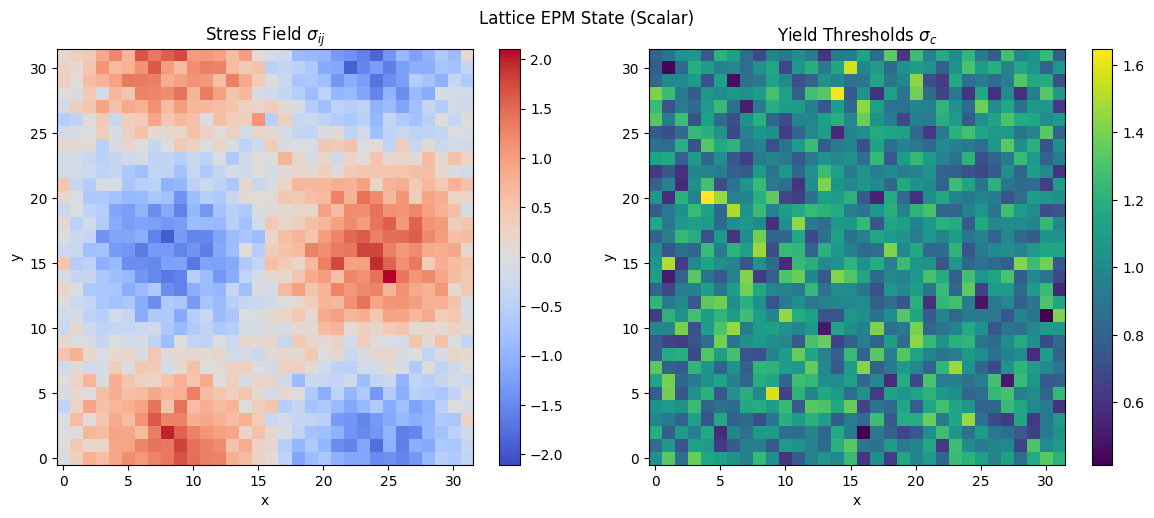

In [4]:
# Scalar stress (LatticeEPM)
print("Scalar stress field (LatticeEPM):")
fig1 = plot_lattice_fields(stress_scalar, thresholds)
display(fig1)
plt.close(fig1)

Tensorial stress field (TensorialEPM):


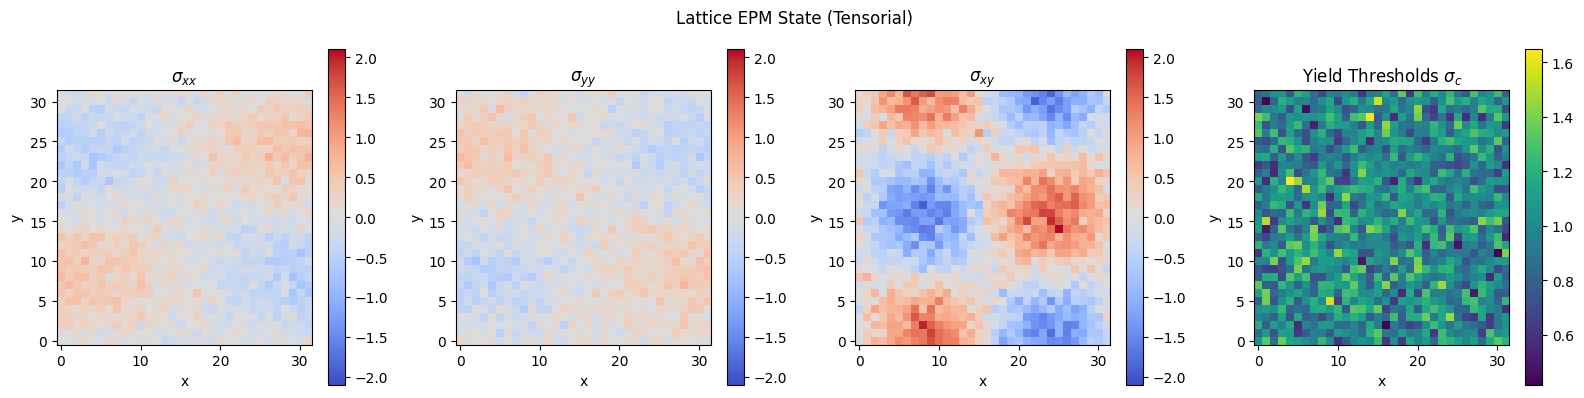

In [5]:
# Tensorial stress (TensorialEPM)
print("Tensorial stress field (TensorialEPM):")
fig2 = plot_lattice_fields(stress_tensor, thresholds)
display(fig2)
plt.close(fig2)

## 5. Tensorial Field Components

For detailed analysis of tensorial stress, use `plot_tensorial_fields()` to see all components.

Tensorial stress components:


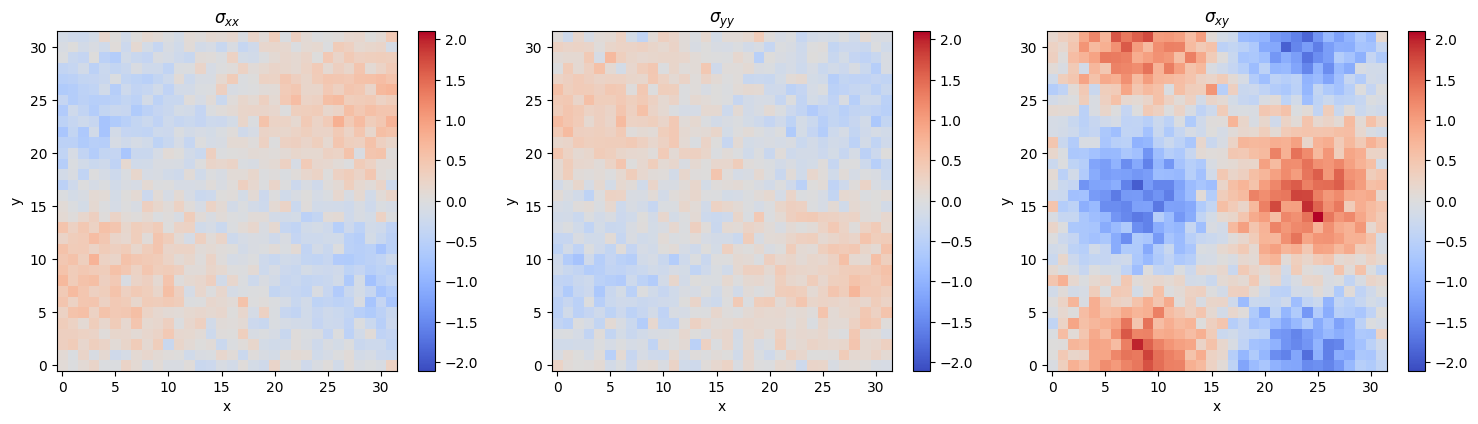

In [6]:
print("Tensorial stress components:")
fig, axes = plot_tensorial_fields(stress_tensor)
display(fig)
plt.close(fig)

**Interpretation:**
- **σ_xx, σ_yy**: Normal stress components (extension/compression in x and y)
- **σ_xy**: Shear stress component (dominant in simple shear flow)
- Spatial patterns reveal stress localization and heterogeneity

## 6. Normal Stress Difference N₁

The first normal stress difference N₁ = σ_xx - σ_yy is a key measure of flow-induced anisotropy.

First normal stress difference N₁ = σ_xx - σ_yy:


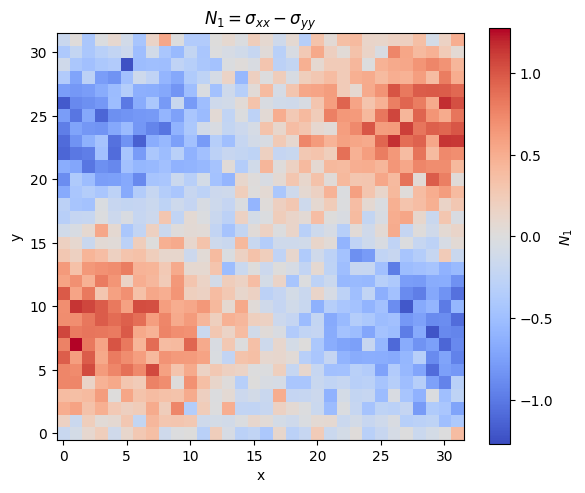


N₁ statistics:
  Mean: -0.0033
  Std:  0.5007
  Range: [-1.2415, 1.2752]


In [7]:
print("First normal stress difference N₁ = σ_xx - σ_yy:")
fig, ax = plot_normal_stress_field(stress_tensor, nu=0.48)
display(fig)
plt.close(fig)

# Compute N₁ statistics
N1 = stress_tensor[0] - stress_tensor[1]
print(f"\nN₁ statistics:")
print(f"  Mean: {np.mean(N1):.4f}")
print(f"  Std:  {np.std(N1):.4f}")
print(f"  Range: [{np.min(N1):.4f}, {np.max(N1):.4f}]")

## 7. Von Mises Effective Stress

The von Mises stress σ_VM combines all stress components into a scalar measure for yielding comparison.

Von Mises effective stress and yield map:


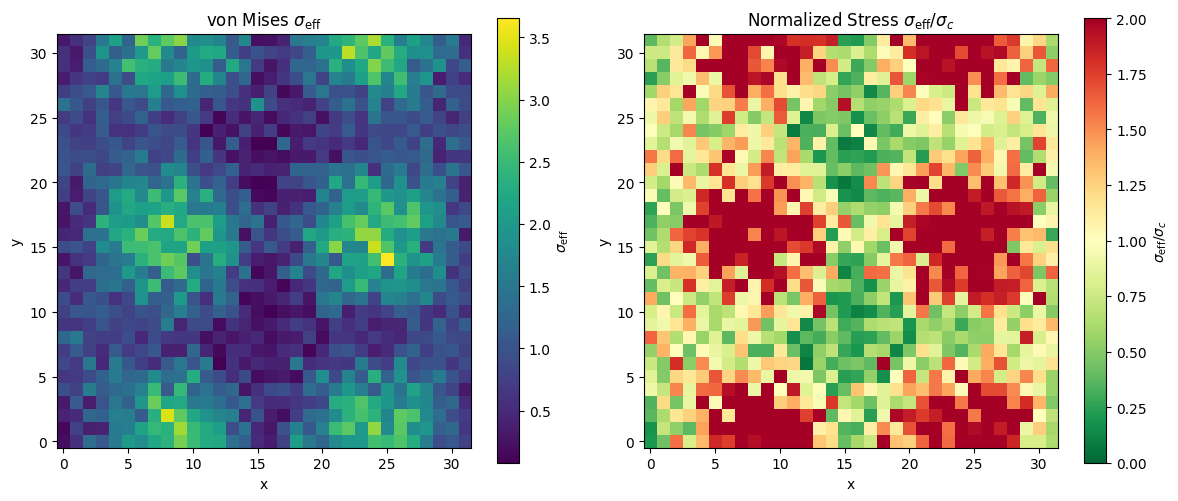

In [8]:
print("Von Mises effective stress and yield map:")
fig, axes = plot_von_mises_field(stress_tensor, thresholds, nu=0.48)
display(fig)
plt.close(fig)

**Interpretation:**
- **Left**: Von Mises stress σ_VM = √(σ_xx² - σ_xx·σ_yy + σ_yy² + 3σ_xy²)
- **Right**: Yield map showing regions where σ_VM > σ_c (active plastic flow)

## 8. Normal Stress Ratio Analysis

The ratio N₁/σ_xy characterizes the material's nonlinearity and is used to compare with polymer rheology.

In [9]:
# Generate flow curve data for ratio analysis
model = TensorialEPM(L=16 if FAST_MODE else 32, dt=0.01, mu=1.0, sigma_c_mean=1.0, sigma_c_std=0.15)

shear_rates = np.logspace(-2, 1, 15)

print("Running TensorialEPM flow curve...")
result = model.predict(shear_rates, test_mode="flow_curve", smooth=True, seed=42)

sigma_xy = np.array(result.y)
N1_flow = np.array(result.metadata.get("N1", np.zeros_like(sigma_xy)))

print(f"σ_xy range: {sigma_xy.min():.3f} – {sigma_xy.max():.3f}")
print(f"N₁ range: {N1_flow.min():.3f} – {N1_flow.max():.3f}")

Running TensorialEPM flow curve...


σ_xy range: 0.075 – 66.456
N₁ range: -0.000 – 0.000


Normal stress ratio N₁/σ_xy vs shear rate:


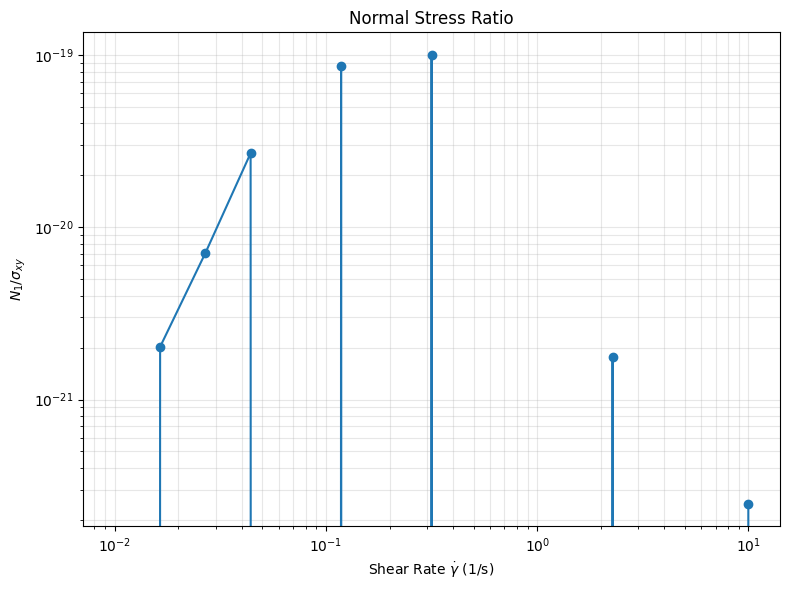

In [10]:
print("Normal stress ratio N₁/σ_xy vs shear rate:")
fig, ax = plot_normal_stress_ratio(shear_rates, N1_flow, sigma_xy)
display(fig)
plt.close(fig)

# Compute power-law exponent
valid_mask = (sigma_xy > 0.01) & (np.abs(N1_flow) > 0.001)
if np.sum(valid_mask) > 3:
    ratio = np.abs(N1_flow[valid_mask]) / sigma_xy[valid_mask]
    log_rates = np.log10(shear_rates[valid_mask])
    log_ratio = np.log10(ratio)
    slope = np.polyfit(log_rates, log_ratio, 1)[0]
    print(f"\nPower-law behavior: N₁/σ_xy ~ γ̇^{slope:.2f}")

## 9. Animation: Stress Evolution

Create an animation showing how stress fields evolve during shear startup.

In [11]:
# Create synthetic stress evolution (shear startup)
print("Creating synthetic stress evolution...")

L_anim = 16  # Smaller lattice for faster animation
T = 25  # Number of frames
time_anim = np.linspace(0, 3.0, T)

stress_history = np.zeros((T, 3, L_anim, L_anim))
x_grid, y_grid = np.meshgrid(np.arange(L_anim), np.arange(L_anim), indexing='ij')

np.random.seed(123)
for t_idx, t in enumerate(time_anim):
    # Build up stress over time (exponential approach to steady state)
    amplitude = 1.0 - np.exp(-t * 1.5)
    
    # Add spatial patterns + time-varying disorder
    stress_history[t_idx, 0] = 0.3 * amplitude * np.sin(2 * np.pi * x_grid / L_anim) + 0.05 * np.random.randn(L_anim, L_anim)
    stress_history[t_idx, 1] = -0.3 * amplitude * np.sin(2 * np.pi * x_grid / L_anim) + 0.05 * np.random.randn(L_anim, L_anim)
    stress_history[t_idx, 2] = amplitude * np.cos(2 * np.pi * x_grid / L_anim) * np.sin(2 * np.pi * y_grid / L_anim) + 0.1 * np.random.randn(L_anim, L_anim)

history_dict = {
    'stress': stress_history,
    'time': time_anim
}

print(f"Stress history shape: {stress_history.shape}")
print(f"Time points: {T}")

Creating synthetic stress evolution...
Stress history shape: (25, 3, 16, 16)
Time points: 25


Creating animation (all stress components)...


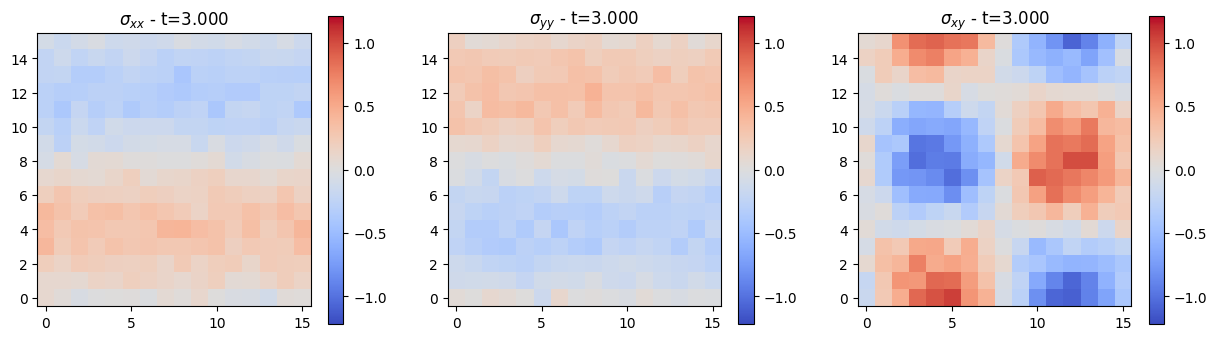

In [12]:
# Create animation (all components)
print("Creating animation (all stress components)...")
anim = animate_tensorial_evolution(history_dict, component='all', interval=150, nu=0.48)

# Display in notebook
HTML(anim.to_jshtml())

Creating animation (von Mises stress)...


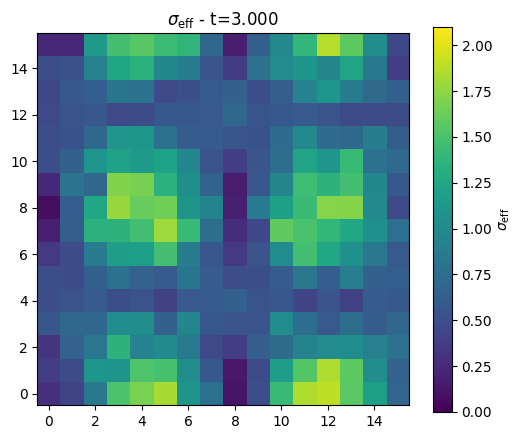

In [13]:
# Create animation (von Mises effective stress)
print("Creating animation (von Mises stress)...")
anim_vm = animate_tensorial_evolution(history_dict, component='vm', interval=150, nu=0.48)

# Display in notebook
HTML(anim_vm.to_jshtml())

## 10. Integration with Protocol Notebooks

These visualization tools can be used with real simulation output from the protocol notebooks.

In [14]:
# Example: Extract stress field from a TensorialEPM simulation
model_example = TensorialEPM(
    L=16 if FAST_MODE else 32, dt=0.01,
    mu=2.0, nu=0.48,
    sigma_c_mean=1.0, sigma_c_std=0.2,
)

# Simulate startup to get a stress field
t_startup = np.linspace(0.1, 5.0, 50)

print("Running TensorialEPM startup simulation...")
result_startup = model_example.predict(
    t_startup, test_mode="startup", gamma_dot=1.0, smooth=False, seed=42
)

# The stress field at the final time step can be extracted from the model state
print(f"Stress output shape: {np.array(result_startup.y).shape}")
print(f"Final stress: {result_startup.y[-1]:.3f} Pa")

# N1 is available in flow_curve protocol but not startup (scalar σ_xy output)
N1_data = result_startup.metadata.get("N1", None) if result_startup.metadata else None
if N1_data is not None:
    print(f"Final N₁: {np.array(N1_data)[-1]:.3f} Pa")
else:
    print("N₁ not available in startup protocol (use flow_curve for N₁ data)")

Running TensorialEPM startup simulation...


Stress output shape: (50,)
Final stress: 0.460 Pa
N₁ not available in startup protocol (use flow_curve for N₁ data)


## 11. Visualization Toolkit Summary

### Quick Reference

```python
from rheojax.visualization.epm_plots import (
    plot_lattice_fields,        # Auto-detect + overview
    plot_tensorial_fields,      # Detailed component view
    plot_normal_stress_field,   # N₁ analysis
    plot_von_mises_field,       # Yielding analysis
    plot_normal_stress_ratio,   # Flow curve N₁/σ_xy
    animate_tensorial_evolution,# Time evolution
)

# Auto-detection example
fig = plot_lattice_fields(stress_field, thresholds)

# Tensorial analysis
fig, axes = plot_tensorial_fields(stress_tensor)
fig, ax = plot_normal_stress_field(stress_tensor, nu=0.48)
fig, axes = plot_von_mises_field(stress_tensor, thresholds)

# Animation
history = {'stress': stress_array, 'time': time_array}
anim = animate_tensorial_evolution(history, component='all')
```

### When to Use Each Tool

| Goal | Function |
|------|----------|
| Quick overview | `plot_lattice_fields()` |
| Detailed stress analysis | `plot_tensorial_fields()` |
| Normal stress effects | `plot_normal_stress_field()` |
| Identify yielding regions | `plot_von_mises_field()` |
| Rheological characterization | `plot_normal_stress_ratio()` |
| Dynamics visualization | `animate_tensorial_evolution()` |

## Key Takeaways

1. **Auto-detection** distinguishes scalar (LatticeEPM) from tensorial (TensorialEPM) fields
2. **Tensorial fields** provide $\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{xy}$ for complete stress state analysis
3. **$N_1 = \sigma_{xx} - \sigma_{yy}$** measures flow-induced anisotropy (Weissenberg effect)
4. **Von Mises stress** $\sigma_{\text{VM}}$ identifies yielding regions in the lattice
5. **Animations** reveal the dynamics of stress buildup, avalanche propagation, and relaxation

## Visualization Toolkit Summary

### Quick Reference

```python
from rheojax.visualization.epm_plots import (
    plot_lattice_fields,        # Auto-detect + overview
    plot_tensorial_fields,      # Detailed component view
    plot_normal_stress_field,   # N₁ analysis
    plot_von_mises_field,       # Yielding analysis
    plot_normal_stress_ratio,   # Flow curve N₁/σ_xy
    animate_tensorial_evolution,# Time evolution
)

# Auto-detection example
fig = plot_lattice_fields(stress_field, thresholds)

# Tensorial analysis
fig, axes = plot_tensorial_fields(stress_tensor)
fig, ax = plot_normal_stress_field(stress_tensor, nu=0.48)
fig, axes = plot_von_mises_field(stress_tensor, thresholds)

# Animation
history = {'stress': stress_array, 'time': time_array}
anim = animate_tensorial_evolution(history, component='all')
```

### When to Use Each Tool

| Goal | Function |
|------|----------|
| Quick overview | `plot_lattice_fields()` |
| Detailed stress analysis | `plot_tensorial_fields()` |
| Normal stress effects | `plot_normal_stress_field()` |
| Identify yielding regions | `plot_von_mises_field()` |
| Rheological characterization | `plot_normal_stress_ratio()` |
| Dynamics visualization | `animate_tensorial_evolution()` |

## Further Reading

**Handbook:**
- [Lattice EPM — Spatial Fields](../../docs/source/models/epm/lattice_epm.rst#field-initialization) — Field initialization and disorder generation
- [Tensorial EPM](../../docs/source/models/epm/tensorial_epm.rst) — Full stress tensor implementation

**Key References:**
- Picard, G., Ajdari, A., Lequeux, F., & Bocquet, L. (2004). "Elastic consequences of a single plastic event: A step towards the microscopic modeling of the flow of yield stress fluids." *European Physical Journal E*, 15, 371-381.
- Nicolas, A., Ferrero, E. E., Martens, K., & Barrat, J.-L. (2018). "Deformation and flow of amorphous solids: Insights from elastoplastic models." *Reviews of Modern Physics*, 90, 045006.
- Budrikis, Z., Castellanos, D. F., Sandfeld, S., Zaiser, M., & Zapperi, S. (2017). "Universal features of amorphous plasticity." *Nature Communications*, 8, 15928.